In [1]:
# --- Open parquet files ---
suppressPackageStartupMessages( library(arrow) )
# --- Execution Time Management ---
suppressPackageStartupMessages( library(tictoc) )
# --- String Manipulation ---
suppressPackageStartupMessages( library(stringr) )
# --- Data Manipulation ---
suppressPackageStartupMessages( library(dplyr) )
# --- unnest ---
suppressPackageStartupMessages( library(tidyr) )
# --- add_column ---
suppressPackageStartupMessages( library(tibble) )
# --- read.xls ---
suppressPackageStartupMessages( library(gdata) )
# --- DTW ---
suppressPackageStartupMessages( library(dtw) )
# --- DTWDistance ---
suppressPackageStartupMessages( library(TSdist) )
# --- Distance matrix function definition ---
suppressPackageStartupMessages( library(proxy) )

# --- Plotting ---
suppressPackageStartupMessages( library(ggplot2) )
suppressPackageStartupMessages( library(cowplot) )

# Cria um tema padrão para o pacote ggplot2
t = theme(plot.title = element_text(size=26, hjust=0.5),
          axis.title = element_text(size=20),
          axis.text = element_text(size=20),
          legend.title = element_text(size = 24),
          legend.text = element_text(size = 20))
theme_set(theme_minimal()+t)

# Tamanho de imagem padrão no notebook
options(repr.plot.width=12, repr.plot.height=6)

# Exemplo do alinhamento DTW

A seguir vemos um exemplo de confirmação do funcionamento do alinhamento DTW. Vemos que duas séries idênticas, mas defasadas no tempo tem sua distância reconhecida como zero, como o esperado.

Séries idênticas defasadas no tempo: 0

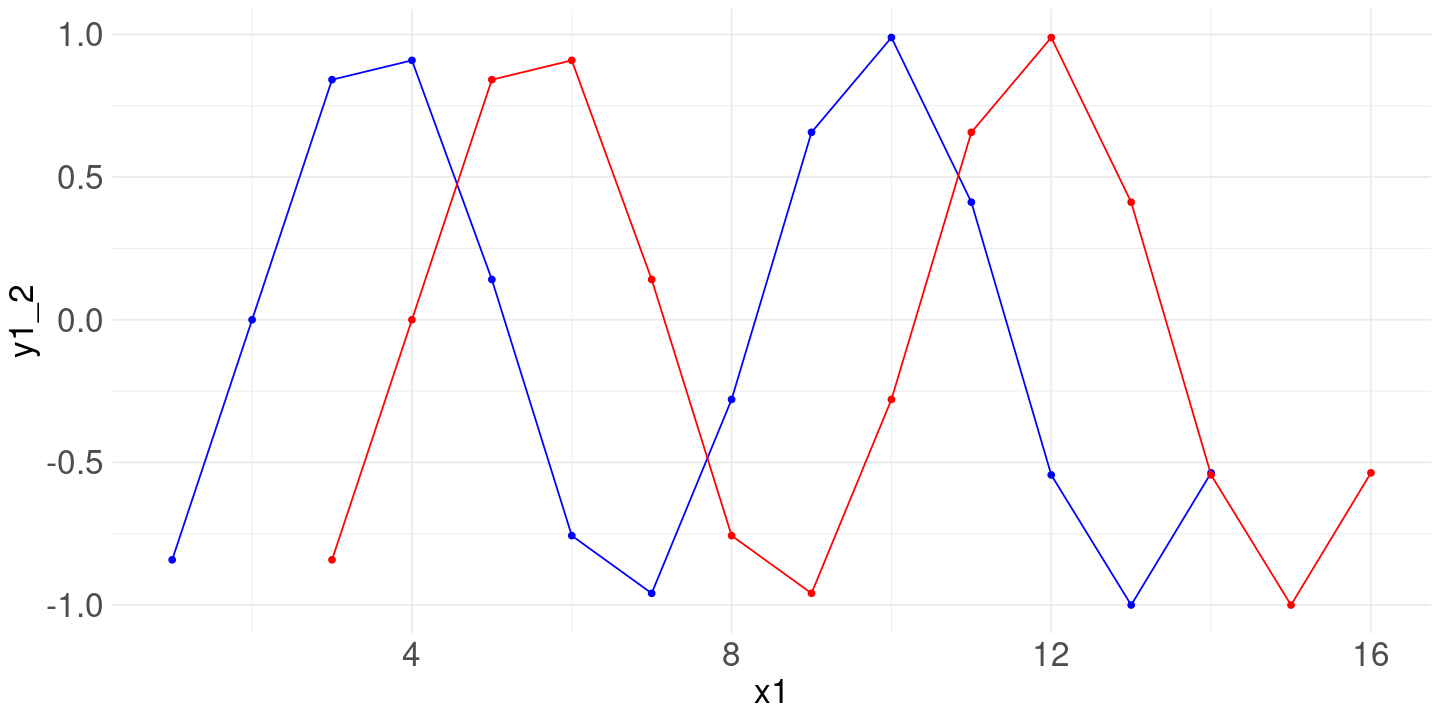

In [2]:
x = seq(1, 16)
y1 = sin(x - 2)
y2 = sin(x - 4)

x1 = x[1:(length(x)-2)]
y1_2 = y1[1:(length(x)-2)]

x2 = x[3:length(x)]
y2_2 = y2[3:length(x)]

cat(paste0("Séries idênticas defasadas no tempo: ", DTWDistance( y1_2, y2_2 )))

ggplot()+
    geom_line(aes(x = x1, y = y1_2), color = "blue")+
    geom_point(aes(x = x1, y = y1_2), color = "blue")+
    geom_line(aes(x = x2, y = y2_2), color = "red")+
    geom_point(aes(x = x2, y = y2_2), color = "red")

# Análise de agrupamentos

In [9]:
df <- read_parquet("Data/data2011to2019_municipios_standardized.parquet")

cat(paste0("Dimensão dos dados: (", nrow(df), ",", ncol(df), ")"))

head(df, 3)

Dimensão dos dados: (5796,10)

ds_municipio,ano_exercicio,vl_despesa,RCL,pib_nominal,populacao,quantidade_total_vagas,vereadores,area,alunos_escola
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Adamantina,2011,-0.8574809,-1.0717022,-0.1733109,-0.1393203,0.01442694,-0.5384357,0.08964684,-0.2458249
Adamantina,2012,-0.9089957,-0.9945574,-0.1733109,-0.1393203,0.01442694,-0.5384357,0.08964684,-0.2458249
Adamantina,2013,-1.0063439,-0.7809420,-0.1733109,-0.1393203,0.01442694,-0.5384357,0.08964684,-0.2458249


In [11]:
df_grouped <- df %>%
    group_by(ds_municipio) %>%
    summarise(
        vl_despesa = list(vl_despesa),
        RCL = list(RCL),
        pib_nominal = first(pib_nominal),
        populacao = first(populacao),
        quantidade_total_vagas = first(quantidade_total_vagas),
        vereadores = first(vereadores),
        area = first(area),
        alunos_escola = first(alunos_escola),
    )

cat(paste0("Número de municípios: ", nrow(df_grouped)))

head(df_grouped, 3)

Número de municípios: 644

ds_municipio,vl_despesa,RCL,pib_nominal,populacao,quantidade_total_vagas,vereadores,area,alunos_escola
<chr>,<list>,<list>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Adamantina,"-0.8574809, -0.9089957, -1.0063439, 0.4516231, 0.5598692, -0.4872304, 0.6629049, -0.2283085, 1.8139621","-1.0717022, -0.9945574, -0.7809420, -0.4877349, -0.2268774, 0.2169858, 0.7569240, 1.0642224, 1.5236817",-0.1733109,-0.1393203,0.01442694,-0.5384357,0.08964684,-0.2458249
Adolfo,"-1.1462101, 1.3986585, -0.3462515, 1.4361547, -0.5356110, -0.5021720, -0.6934159, 0.7250624, -0.3362152","-1.4524280, -1.1826487, -0.6547503, -0.2247187, 0.1672190, 0.4092617, 0.8689316, 0.9069862, 1.1621472",-0.3170419,-0.4004361,-0.36721695,-0.5384357,-0.54072455,-0.4512276
Aguaí,"0.4451480, -1.2620307, -0.7294458, 1.1621114, -0.4224709, 0.5766417, -1.1752820, 0.1745164, 1.2308118","-1.2815911, -1.1443155, -0.4692985, -0.2761106, -0.1599776, 0.2987632, 0.4204305, 1.0236029, 1.5884968",-0.1901456,-0.1315911,-0.11682494,0.6944624,0.28821382,-0.1224304


Com os dados já padronizados e preparados para a aplicação do algoritmo de agrupamento, basta definirmos a função que corresponde à métrica criada para os municípios.

In [20]:
distances = proxy::dist(df_grouped, function(x,y){
    dist_despesa = DTWDistance( unlist(x[[2]]), unlist(y[[2]]) ) # Distância
    dist_RCL = DTWDistance( unlist(x[[3]]), unlist(y[[3]]) )
    pib_nominal = x[[4]][1] - y[[4]][1]
    populacao = x[[5]][1] - y[[5]][1]
    quantidade_total_vagas = x[[6]][1] - y[[6]][1]
    vereadores = x[[7]][1] - y[[7]][1]
    alunos_escola = x[[8]][1] - y[[8]][1]
    area = x[[9]][1] - y[[9]][1]
    
    return(sqrt(sum(c(dist_despesa, dist_RCL, pib_nominal, populacao, quantidade_total_vagas, vereadores, alunos_escola, area)^2)))
})